In [1]:
import numpy as np
import cv2
from EstimateFundamentalMatrix import *
from GetInliersRANSAC import *
from EssentialMatrixFromFundamentalMatrix import *
from ExtractCameraPose import *
from LinearTriangulation import *
from NonLinearTriangulation import *
from DisambiguateCameraPose  import *
from PnPRansac import *
from NonLinearPnP import *
from BundleAdjustment import *
from Utils.ImageUtils import *
from Utils.DataLoader import *
from Utils.MiscUtils import *
from matplotlib import pyplot as plt
import scipy.optimize as optimize
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares


K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0, 0, 1]]).reshape(3,3)

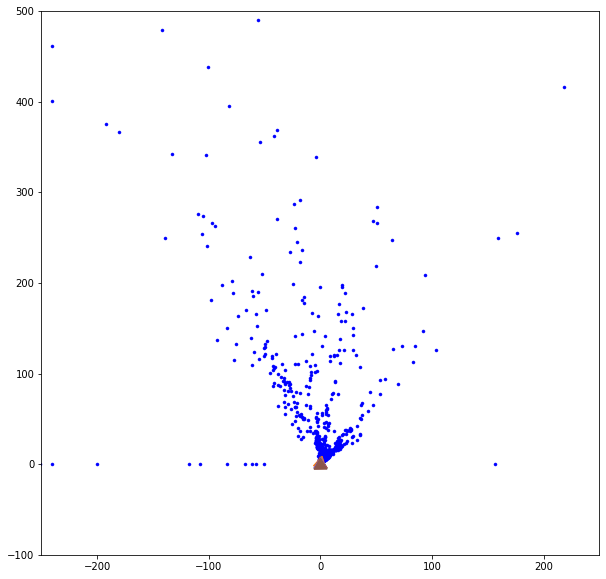

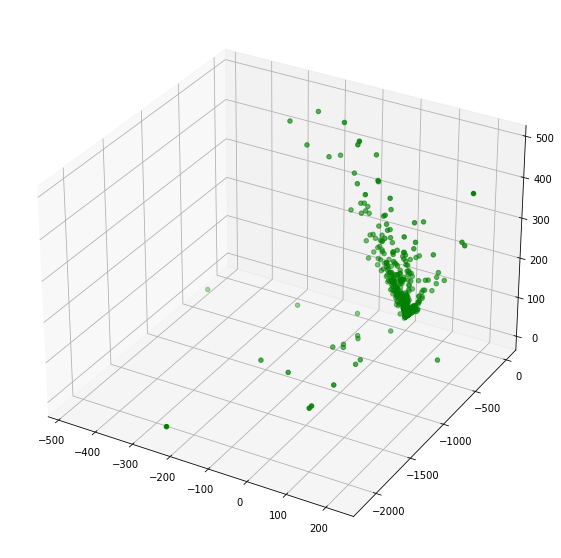

In [7]:
C_set = np.load('../outputs/optimized_C_set_.npy')
R_set = np.load('../outputs/optimized_R_set_.npy')
X_all = np.load('../outputs/optimized_X_all.npy')
X_found = np.load('../outputs/optimized_X_found.npy')
# savepath = '../outputs/'
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
x = X[:,0]
y = X[:,1]
z = X[:,2]
x[(x < -500) | (x > 500)] = 0 
y[(x < -500) | (x > 500)] = 0 
z[(z <= 0) | (z > 500)] = 0

# 2D plotting
fig = plt.figure(figsize = (10, 10))
plt.xlim(-250,  250)
plt.ylim(-100,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')
for i in range(0, len(C_set)):
    R1 = getEuler(R_set[i])
    R1 = np.rad2deg(R1)
    plt.plot(C_set[i][0],C_set[i][2], marker=(3, 0, int(R1[1])), markersize=15, linestyle='None')

# plt.savefig(savepath+'2D.png')
plt.show()

# For 3D plotting
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.show()
# plt.savefig(savepath+'3D.png')

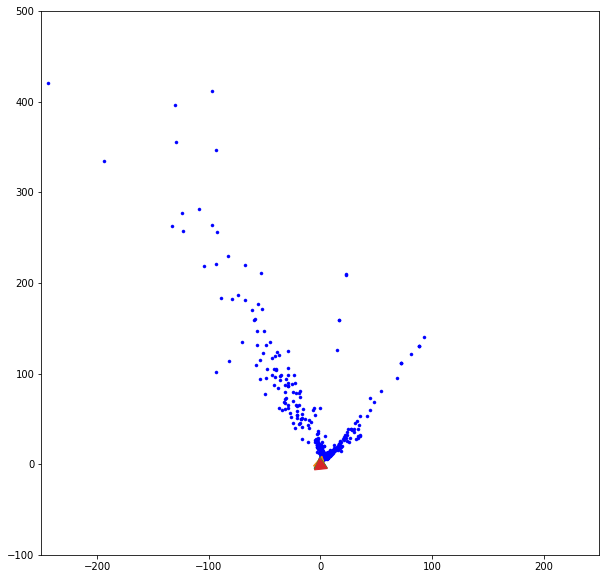

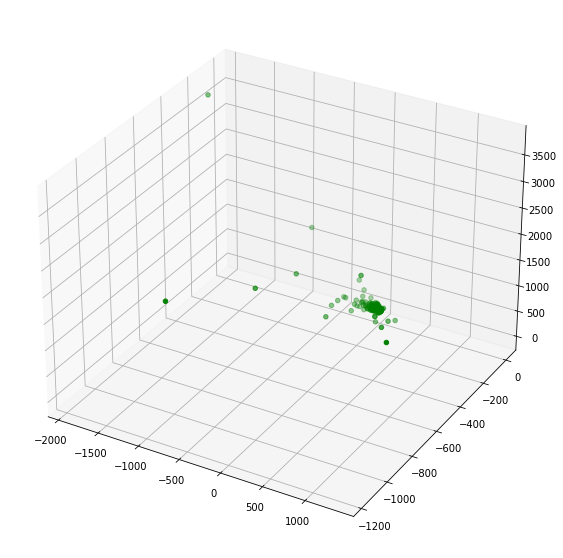

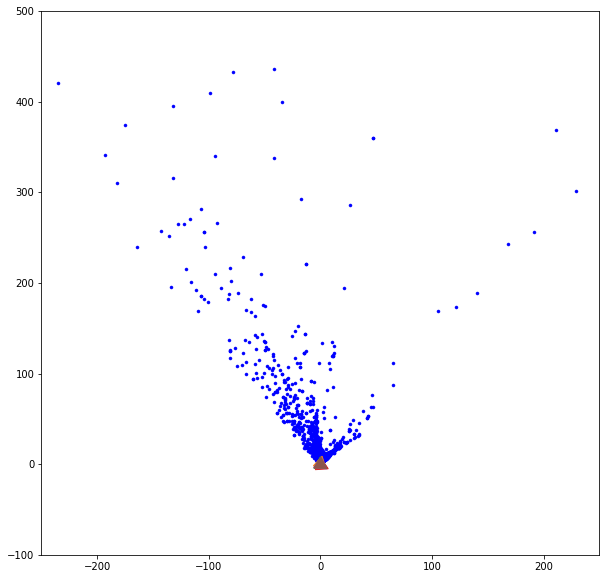

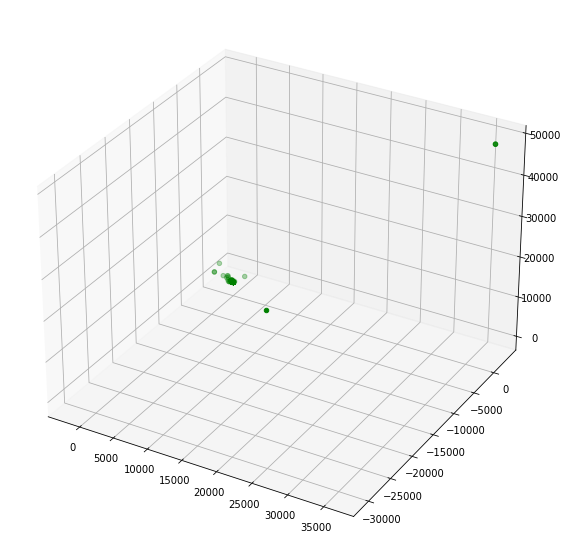

In [6]:
C_set = np.load('../outputs_noBA/optimized_C_set_.npy')
R_set = np.load('../outputs_noBA/optimized_R_set_.npy')
X_all = np.load('../outputs_noBA/optimized_X_all.npy')
X_found = np.load('../outputs_noBA/optimized_X_found.npy')
# savepath = '../outputs/'
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
x = X[:,0]
y = X[:,1]
z = X[:,2]
# x[(x < -500) | (x > 500)] = 0 
# y[(x < -500) | (x > 500)] = 0 
# z[(z <= 0) | (z > 500)] = 0

# 2D plotting
fig = plt.figure(figsize = (10, 10))
plt.xlim(-250,  250)
plt.ylim(-100,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')
for i in range(0, len(C_set)):
    R1 = getEuler(R_set[i])
    R1 = np.rad2deg(R1)
    plt.plot(C_set[i][0],C_set[i][2], marker=(3, 0, int(R1[1])), markersize=15, linestyle='None')

# plt.savefig(savepath+'2D.png')
plt.show()

# For 3D plotting
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.show()
# plt.savefig(savepath+'3D.png')

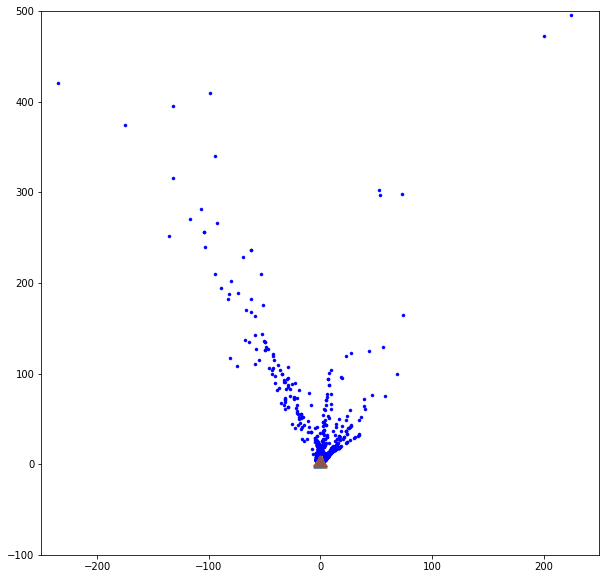

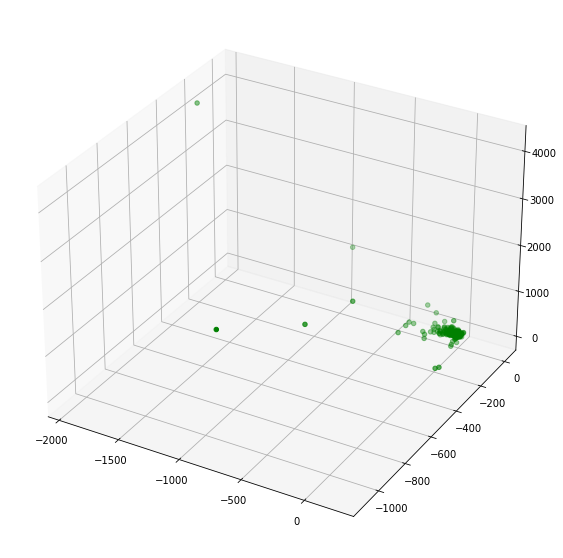

In [20]:
load_data = False
BA = True

folder_name = "../Data/"
total_images = 6
images = readImageSet(folder_name, total_images)

"""
 read the feature correspondencs as n x n_images matrix, 
 if image 1 and image 2 have correspondences, then column 1 and column 2 has data in it

 In every row, the non zero column positions signify that there are point correspondences between those images
""" 
feature_x, feature_y,  feature_flag, feature_descriptor = extractMatchingFeaturesFromFileNew(folder_name, total_images)



if load_data:
    print('Bypassing inliers RANSAC procedure with pre-filtered data')
    filtered_feature_flag = np.load('./tmp_files/filtered_feature_flag.npy', allow_pickle=True)
    f_matrix = np.load('./tmp_files/f_matrix.npy', allow_pickle=True)
else:        
    filtered_feature_flag = np.zeros_like(feature_flag)
    f_matrix = np.empty(shape=(total_images, total_images), dtype=object)

    for i in range(0, total_images - 1):
        # filtered_feature_flag[:, i] = feature_descriptor[:,i]
        for j in range(i + 1, total_images):

            idx = np.where(feature_flag[:,i] & feature_flag[:,j])
            pts1 = np.hstack((feature_x[idx, i].reshape((-1, 1)), feature_y[idx, i].reshape((-1, 1))))
            pts2 = np.hstack((feature_x[idx, j].reshape((-1, 1)), feature_y[idx, j].reshape((-1, 1))))
            # showMatches(images[i], images[j], pts1, pts2, (0,255,0), None)
            idx = np.array(idx).reshape(-1)
            # print(len(idx))
            if len(idx) > 8:
                F_best, chosen_idx = getInliers(pts1, pts2, idx)
                print('At image : ',  i,j, '|| Number of inliers: ', len(chosen_idx), '/', len(idx) )            
                f_matrix[i, j] = F_best
                filtered_feature_flag[chosen_idx, j] = 1
                filtered_feature_flag[chosen_idx, i] = 1


Reading images from  ../Data/
At image :  0 1 || Number of inliers:  503 / 1426
At image :  0 2 || Number of inliers:  271 / 608
At image :  0 3 || Number of inliers:  165 / 470
At image :  1 2 || Number of inliers:  667 / 2052
At image :  1 3 || Number of inliers:  289 / 1073
At image :  2 3 || Number of inliers:  572 / 2293
At image :  2 4 || Number of inliers:  497 / 963
At image :  2 5 || Number of inliers:  271 / 449
At image :  3 4 || Number of inliers:  838 / 2160
At image :  3 5 || Number of inliers:  547 / 1151
At image :  4 5 || Number of inliers:  680 / 1965


In [21]:
np.save('filtered_feature_flag.npy',filtered_feature_flag)
np.save('f_matrix.npy',f_matrix)

In [26]:
filtered_feature_flag = np.load('./tmp_files/filtered_feature_flag.npy', allow_pickle=True)
f_matrix = np.load('./tmp_files/f_matrix.npy', allow_pickle=True)

In [27]:
######################################## Obtained Feature points  ##########################################################

"""
Register First two Images
"""      
print('Registering images 1 and 2 ...... ')
print('Estimating Relative Pose of Camera 2 w.r to camera 1 ...')
n,m = 0,1
F12 = f_matrix[n,m]
E12 = getEssentialMatrix(K, F12)
R_set, C_set = ExtractCameraPose(E12)

idx = np.where(filtered_feature_flag[:,n] & filtered_feature_flag[:,m])
pts1 = np.hstack((feature_x[idx, n].reshape((-1, 1)), feature_y[idx, n].reshape((-1, 1))))
pts2 = np.hstack((feature_x[idx, m].reshape((-1, 1)), feature_y[idx, m].reshape((-1, 1))))

R1 = np.identity(3)
C1 = np.zeros((3,1))
I = np.identity(3)
pts3D_4 = []
for i in range(len(C_set)):
    pts3D = []
    x1 = pts1
    x2 = pts2
    X = LinearTriangulation(K, C1, R1, C_set[i], R_set[i], x1, x2)
    X = X/X[:,3].reshape(-1,1)
    pts3D_4.append(X)


R_chosen, C_chosen, X = DisambiguatePose(R_set, C_set, pts3D_4)
X = X/X[:,3].reshape(-1,1)
print(' Done.')
print('Performing Non Linear Triangulation ...')
X_refined = NonLinearTriangulation(K, pts1, pts2, X, R1, C1, R_chosen, C_chosen)
X_refined = X_refined / X_refined[:,3].reshape(-1,1)
print(' Done')
print(X.shape, R1.shape, pts1.shape)
mean_error1 = meanReprojectionError(X, pts1, pts2, R1, C1, R_chosen, C_chosen, K )
mean_error2 = meanReprojectionError(X_refined, pts1, pts2, R1, C1, R_chosen, C_chosen, K )

print('Before LT optimization: ', mean_error1, 'After LT optimization :', mean_error2)


############################################################################################################
######################################## Register Camera 1 and 2  ##########################################

X_all = np.zeros((feature_x.shape[0], 3))
camera_indices = np.zeros((feature_x.shape[0], 1), dtype = int) 
X_found = np.zeros((feature_x.shape[0], 1), dtype = int)

X_all[idx] = X[:, :3]
X_found[idx] = 1
camera_indices[idx] = 1

# print(np.nonzero(X_found[idx])[0].shape)
X_found[np.where(X_all[:,2] < 0)] = 0
# print(len(idx[0]), '--' ,np.nonzero(X_found[idx])[0].shape)

C_set_ = []
R_set_ = []

C0 = np.zeros(3)
R0 = np.identity(3)
C_set_.append(C0)
R_set_.append(R0)

C_set_.append(C_chosen)
R_set_.append(R_chosen)
print(' #####################  Registered Cameras 1 and 2 #####################' )
############################################################################################################
######################################## Registering Remaining images  #####################################
print('Registering remaining Images ......')

for i in range(2, total_images):
    
    print('Registering Image: ', str(i+1) ,'......')
    feature_idx_i = np.where(X_found[:, 0] & filtered_feature_flag[:, i])
    if len(feature_idx_i[0]) < 8:
        print("Found ", len(feature_idx_i), "common points between X and ", i, " image")
        continue

    pts_i = np.hstack((feature_x[feature_idx_i, i].reshape(-1,1), feature_y[feature_idx_i, i].reshape(-1,1)))

    
    X = X_all[feature_idx_i, :].reshape(-1,3)
    
    #PnP
    R_init, C_init = PnPRANSAC(K, pts_i, X, n_iterations = 1000, error_thresh = 5)
    
    Ri, Ci = NonLinearPnP(K, pts_i, X, R_init, C_init)
    
    C_set_.append(Ci)
    R_set_.append(Ri)

    #trianglulation
    for j in range(0, i):
        
        # idx_X_pts = np.where(X_found[:, 0] & filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        idx_X_pts = np.where(filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        if (len(idx_X_pts[0]) < 8):
            continue

        x1 = np.hstack((feature_x[idx_X_pts, j].reshape((-1, 1)), feature_y[idx_X_pts, j].reshape((-1, 1))))
        x2 = np.hstack((feature_x[idx_X_pts, i].reshape((-1, 1)), feature_y[idx_X_pts, i].reshape((-1, 1))))
        
        X = LinearTriangulation(K, C_set_[j], R_set_[j], Ci, Ri, x1, x2)
        X = X/X[:,3].reshape(-1,1)
        
        LT_error = meanReprojectionError(X, x1, x2, R_set_[j], C_set_[j], Ri, Ci, K)
        PnP_error = meanReprojectionError(X, x1, x2, R_set_[j], C_set_[j], R_init, C_init, K)
        print(i, j, '|| Before PnP optimization: ', PnP_error, 'After PnP optimization :', LT_error)        
        X = NonLinearTriangulation(K, x1, x2, X, R_set_[j], C_set_[j], Ri, Ci)
        X = X/X[:,3].reshape(-1,1)
        nLT_error = meanReprojectionError(X, x1, x2, R_set_[j], C_set_[j], Ri, Ci, K)
        print(i,j, '|| Before LT optimization: ', LT_error, 'After NLT optimization :', nLT_error)
        
        X_all[idx_X_pts] = X[:,:3]
        X_found[idx_X_pts] = 1
        X_found[X_all[:,2]>0]= 0
        
        print("    - appended ", len(idx_X_pts[0]), " points between ", j+1 ," and ", i+1)
    
    BA = True
    if BA:
        print( 'Performing Bundle Adjustment  for image : ', i  )
        
        R_set_, C_set_, X_all = BundleAdjustment(X_all,X_found, feature_x, feature_y, filtered_feature_flag, R_set_, C_set_, K, nCam = i)
        for j in range(0, i):
            idx_X_pts = np.where(filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
            x1 = np.hstack((feature_x[idx_X_pts, j].reshape((-1, 1)), feature_y[idx_X_pts, j].reshape((-1, 1))))
            x2 = np.hstack((feature_x[idx_X_pts, i].reshape((-1, 1)), feature_y[idx_X_pts, i].reshape((-1, 1))))
            X = X_all[idx_X_pts]
            BA_error = meanReprojectionError(homo(X), x1, x2, R_set_[j], C_set_[j], R_set_[i], C_set_[i], K)
            print(i, j, '| Error after BA :', BA_error)
    print('##################### Registered Camera : ', i+1, '######################')

Registering images 1 and 2 ...... 
Estimating Relative Pose of Camera 2 w.r to camera 1 ...
 Done.
Performing Non Linear Triangulation ...
 Done
(602, 4) (3, 3) (602, 2)
Before LT optimization:  15.35018676707696 After LT optimization : 15.25197935823187
 #####################  Registered Cameras 1 and 2 #####################
Registering remaining Images ......
Registering Image:  3 ......
2 0 || Before PnP optimization:  899.5255244534169 After PnP optimization : 151.33980814809487
2 0 || Before LT optimization:  151.33980814809487 After NLT optimization : 132.74583359337757
    - appended  283  points between  1  and  3
2 1 || Before PnP optimization:  36941.628059124174 After PnP optimization : 4344.9499930405145
2 1 || Before LT optimization:  4344.9499930405145 After NLT optimization : 304.2121087624116
    - appended  750  points between  2  and  3
Performing Bundle Adjustment  for image :  2
5606 4029
   Iteration     Total nfev        Cost      Cost reduction    Step norm     O

/home/gokul/CMSC733/sakshi_project3/Code/BundleAdjustment.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RC_list = np.array(RC_list).reshape(-1, 6)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7744e+08                                    3.97e+10    
       1              7         1.7696e+08      4.73e+05       1.77e+01       3.95e+10    
       2              8         1.7630e+08      6.62e+05       1.05e+01       3.93e+10    
       3              9         1.7563e+08      6.74e+05       7.55e+00       3.90e+10    
       4             19         1.7563e+08      0.00e+00       0.00e+00       3.90e+10    
`xtol` termination condition is satisfied.
Function evaluations 19, initial cost 1.7744e+08, final cost 1.7563e+08, first-order optimality 3.90e+10.
time to run BA : 39.521122455596924 s 
A matrix shape:  (9136, 6342) 
############
3 0 | Error after BA : 1771457.4511039772
3 1 | Error after BA : 1909.0358540517873
3 2 | Error after BA : 462.92891113284827
##################### Registered Camera :  4 ######################
Registering Image:  5 ......

KeyboardInterrupt: 

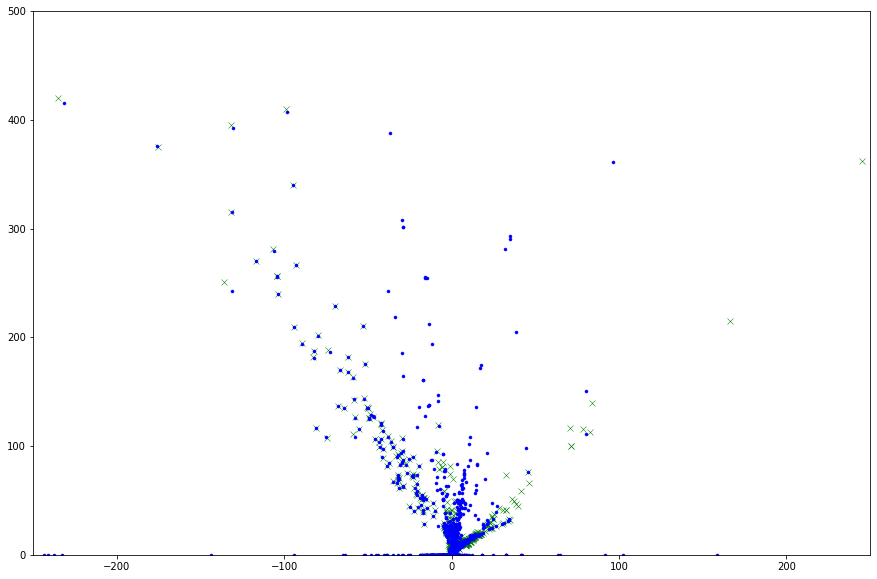

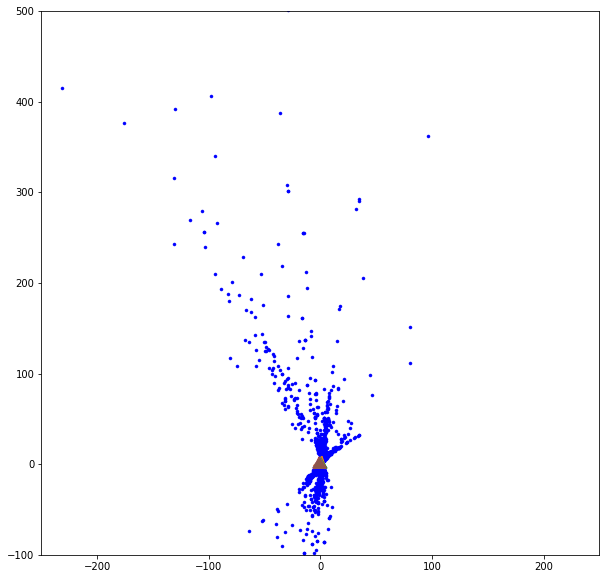

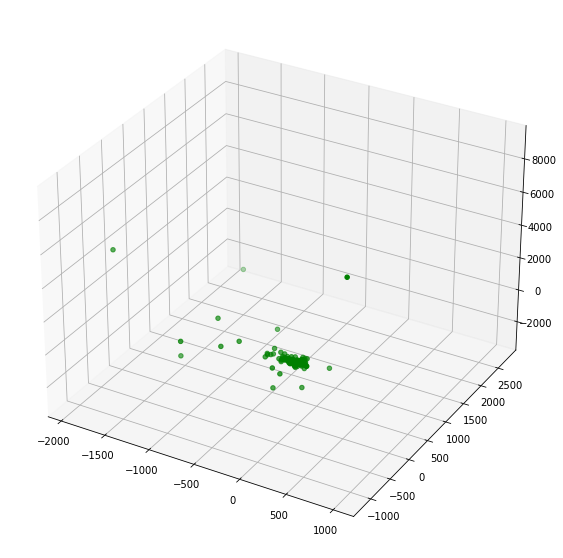

In [7]:
C_set = np.load('./tmp_files/optimized_C_set_.npy')
R_set = np.load('./tmp_files/optimized_R_set_.npy')
X_all = np.load('./tmp_files/optimized_X_all.npy')
X_found = np.load('./tmp_files/optimized_X_found.npy')
# savepath = '../outputs/'
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
x = X[:,0]
y = X[:,1]
z = X[:,2]
# x[(x < -500) | (x > 500)] = 0 
# y[(x < -500) | (x > 500)] = 0 
# z[(z <= 0) | (z > 500)] = 0

# 2D plotting
fig = plt.figure(figsize = (10, 10))
plt.xlim(-250,  250)
plt.ylim(-100,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')
for i in range(0, len(C_set)):
    R1 = getEuler(R_set[i])
    R1 = np.rad2deg(R1)
    plt.plot(C_set[i][0],C_set[i][2], marker=(3, 0, int(R1[1])), markersize=15, linestyle='None')

# plt.savefig(savepath+'2D.png')
plt.show()

# For 3D plotting
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.show()
# plt.savefig(savepath+'3D.png')


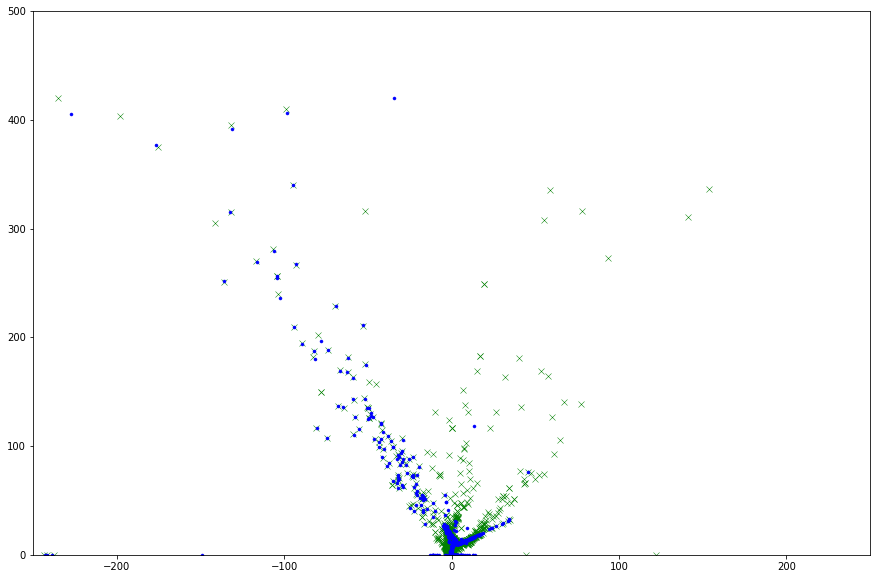

In [21]:
C_set_ = np.load('./tmp_files/optimized_C_set_.npy')
R_set_ = np.load('./tmp_files/optimized_R_set_.npy')
X_all = np.load('./tmp_files/optimized_X_all.npy')
X_found_ = np.load('./tmp_files/optimized_X_found.npy')

C_set_before = np.load('./tmp_files/C_set.npy')
R_set_before = np.load('./tmp_files/R_set.npy')
X_all_before = np.load('./tmp_files/X_all.npy')
X_found_before = np.load('./tmp_files/X_found.npy')

fig = plt.figure(figsize = (15,10))

feature_idx = np.where(X_found_before[:, 0])
X_before = X_all_before[feature_idx]
x1 = X_before[:,0]
z1 = X_before[:,2]
x1[(x1 < -500) | (x1 > 500)] = 0 
z1[(z1 <= 0) | (z1 > 500)] = 0

plt.xlim(-250,  250)
plt.ylim(0,  500)
plt.scatter(x1, z1, marker='x',linewidths=0.5, color = 'green')


feature_idx = np.where(X_found_[:, 0])
X = X_all[feature_idx]

x = X[:,0]
z = X[:,2]
x[(x < -500) | (x > 500)] = 0 
z[(z <= 0) | (z > 500)] = 0

plt.xlim(-250,  250)
plt.ylim(0,  500)
plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')

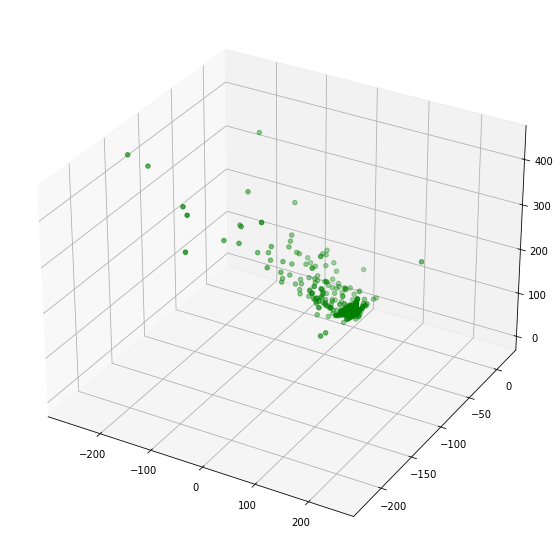

In [20]:
from mpl_toolkits import mplot3d

feature_idx = np.where(X_found_before[:, 0])
X = X_all_before[feature_idx]

x = X[:,0]
y = X[:,1]
z = X[:,2]
# x[(x < -500) | (x > 500)] = 0 
# y[(y < -500) | (y > 500)] = 0 
# z[(z <= 0) | (z > 500)] = 0

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.show()

In [29]:

feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]

x = X[:,0]
y = X[:,1]
z = X[:,2]

x[(x < -500) | (x > 500)] = 0 
y[(y < -500) | (y > 500)] = 0 
z[(z <= 0) | (z > 500)] = 0

ax = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
# Data for three-dimensional scattered points
ax.scatter(x,y,z, s=1)  # cmap='viridis',plt.show()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-250,  250])
ax.set_ylim([-250,  250])
ax.set_zlim([0,  500])
plt.show()

# plt.scatter(x, z, marker='.',linewidths=0.5, color = 'blue')

<Figure size 720x720 with 0 Axes>

In [7]:
C_set_ = np.load('./tmp_files/optimized_C_set_.npy')
R_set_ = np.load('./tmp_files/optimized_R_set_.npy')
X_all_ = np.load('./tmp_files/optimized_X_all.npy')
X_found_ = np.load('./tmp_files/optimized_X_found.npy')

In [8]:
for i in range(2, total_images):
    for j in range(0, i):
        idx_X_pts = np.where(X_found_[:,0] & filtered_feature_flag[:, j] & filtered_feature_flag[:, i])
        if (len(idx_X_pts[0]) < 8):
            continue

        x1 = np.hstack((feature_x[idx_X_pts, j].reshape((-1, 1)), feature_y[idx_X_pts, j].reshape((-1, 1))))
        x2 = np.hstack((feature_x[idx_X_pts, i].reshape((-1, 1)), feature_y[idx_X_pts, i].reshape((-1, 1))))
        
        X = X_all_[idx_X_pts]
        
        BA_error = meanReprojectionError(homo(X), x1, x2, R_set_[j], C_set_[j], R_set_[i], C_set_[i], K)
        print(i+1, j+1, '|| After PnP optimization :', BA_error)        
        

3 1 || After PnP optimization : 11333.987170787745
3 2 || After PnP optimization : 1256.4264956700379
4 1 || After PnP optimization : 13259.496527363603
4 2 || After PnP optimization : 2205.6126808605563
4 3 || After PnP optimization : 1955.354007807436
5 3 || After PnP optimization : 7178.225833477868
5 4 || After PnP optimization : 698.3976100884153
6 3 || After PnP optimization : 13383.302024096198
6 4 || After PnP optimization : 1148.7506809885003
6 5 || After PnP optimization : 20.228185933315512


## Visualize matches

In [3]:
for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        
        if feature_matrix[n,m] is not None:
            feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            matched_pairs = feature[:,3:7]
        else:
            matched_pairs = None

        if filtered_feature_matrix[n,m] is not None:
            filtered_feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            filtered_matched_pairs = filtered_feature[:,3:7]
        else:
            filtered_matched_pairs = None

        showMatches(images[n], images[m], matched_pairs, (0, 255, 0), None)
        showMatches(images[n], images[m], filtered_matched_pairs, (0, 0, 255),"../Results/" + str(n) + str(m) + ".jpg")

## Get 3D points

In [4]:
# R2_, C2_ = p_matrix[1,2]
# matched_pairs = filtered_feature_matrix[1,2]
l = 0
p = 1
R2_, C2_ = p_matrix[l,p]
matched_pairs = filtered_feature_matrix[l,p]
R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
# P1 = np.dot(K, np.dot(R1_, np.hstack((I, -C1_))))
P1 = np.dot(K, np.hstack((R1_, C1_)))


pts3D_4 = []
for i in range(len(C2_)):
    pts3D = []
    x1 = matched_pairs[:,3:5]
    x2 = matched_pairs[:,5:7]

    P2 = np.dot(K, np.dot(R2_[i], np.hstack((I, -C2_[i].reshape(3,1)))))
    #P2 = np.dot(K, np.hstack((R2_[i], C2_[i].reshape(3,1))))

    # X = cv2.triangulatePoints(P1, P2, x1, x2)  
    X = LinearTriangulation(K, C1_, R1_, C2_[i], R2_[i], x1, x2)
    # X = X/X[3,:]
    pts3D_4.append(X)


## Reproject 3D points to 2D

In [5]:
def project3DPoints(K, R, C, X, image, points):
    P = np.dot(K, np.dot(R, np.hstack((I, -C.reshape(3,1)))))
    x = np.dot(P, X.T)
    # x01 = np.dot(P1, X01.T)

    x = x/x[2,:]

    xi = x[0, :].T
    yi = x[1, :].T
    im = image.copy()
    for i in range(matched_pairs.shape[0]):

        x1, y1 = xi[i], yi[i]
        x2, y2 = points[i, 0], points[i, 1]
        cv2.circle(im, (int(x1), int(y1)), 3, (0,0,255), 3)
        cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

    cv2.imshow("im", im)
    cv2.waitKey() 
    cv2.destroyAllWindows()

In [6]:
k = 2
project3DPoints(K, R2_[k], C2_[k], pts3D_4[k], images[p], matched_pairs[:, 5:7])

## Plot 3D points

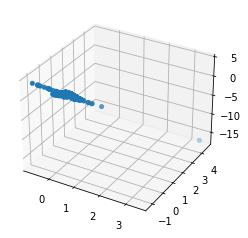

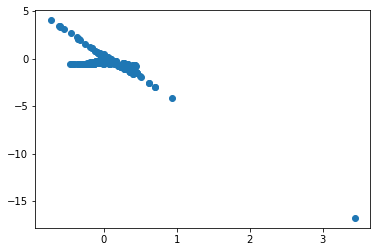

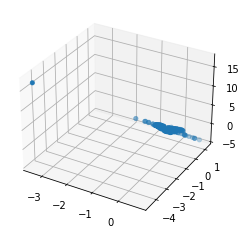

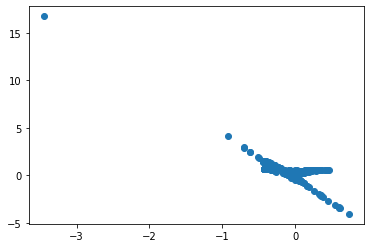

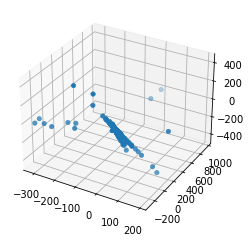

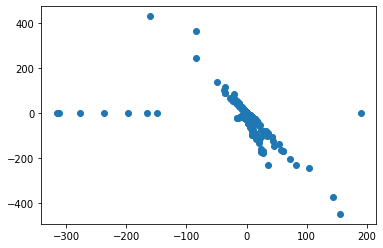

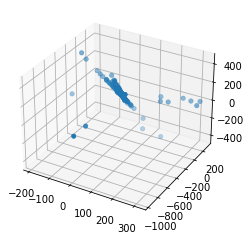

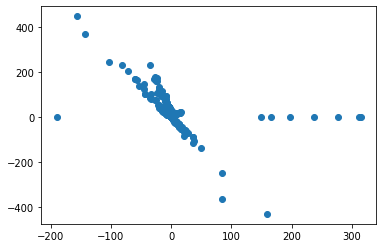

In [7]:
for i in range(len(pts3D_4)):
    # print(pts3D.shape)

    pts3D = pts3D_4[i]
    # X = X/X[3,:]

    pts3D = pts3D/pts3D[:,3].reshape(-1,1)
    x = pts3D[:,0]
    x[(x > 500) | (x < -500)] = 0
    y = pts3D[:,1]
    # y[(y > 500) | (y < -500)] = 0
    # plt.scatter(x, y, linewidths = 0.1)
    z = pts3D[:,2]
    z[(z > 500) | (z < -500)] = 0 


    fig = plt.figure()
    
#     for m in range(0, total_images):
#         if f_matrix[n, m] is not None:
#             e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])

# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if e_matrix[n, m] is not None:
#             p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])
    ax = plt.axes(projection='3d')
    ax.scatter(x,y, z, linewidth=0.5)

    fig = plt.figure()
    plt.scatter(x,z)



In [8]:
R2, C2, X = DisambiguatePose(R2_, C2_, pts3D_4)
X = X/X[:,3].reshape(-1,1)
# x = X[:,0]
# y = X[:,1]
# z = X[:,2]
# fig = plt.figure()
# plt.scatter(x,z)


## Non-Linear Triangulation

In [11]:
pts1 = matched_pairs[:,3:5]
pts2 = matched_pairs[:,5:7]
x3D = X
R1, C1, = R1_, C1_
X_refined = NonLinearTriangulation(K, pts1, pts2, x3D, R1, C1, R2, C2)
X_refined = X_refined / X_refined[:,3].reshape(-1,1)


### Plot 3D and reproject

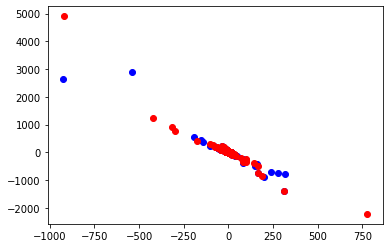

In [12]:
x_refined = X_refined[:,0]
y_refined = X_refined[:,1]
z_refined = X_refined[:,2]

x = X[:,0]
y = X[:,1]
z = X[:,2]

fig = plt.figure()
plt.scatter(x,z, color = 'blue')
plt.scatter(x_refined, z_refined, color='red')

project3DPoints(K, R2, C2, X_refined, images[p], matched_pairs[:, 5:7])

## PnP

In [13]:
def PnP(X_set, x_set, K):
    N = X_set.shape[0]
    
    # X_4 = homo(X_set)
    X_4 = X_set
    x_3 = homo(x_set)
    
    # normalize x
    K_inv = np.linalg.inv(K)
    x_n = K_inv.dot(x_3.T).T
    
    for i in range(N):
        X = X_4[i].reshape((1, 4))
        zeros = np.zeros((1, 4))
        
        u, v, _ = x_n[i]
        
        u_cross = np.array([[0, -1, v],
                            [1,  0 , -u],
                            [-v, u, 0]])
        X_tilde = np.vstack((np.hstack((   X, zeros, zeros)), 
                            np.hstack((zeros,     X, zeros)), 
                            np.hstack((zeros, zeros,     X))))
        a = u_cross.dot(X_tilde)
        
        if i > 0:
            A = np.vstack((A, a))
        else:
            A = a
            
    _, _, VT = np.linalg.svd(A)
    P = VT[-1].reshape((3, 4))
    R = P[:, :3]
    U_r, D, V_rT = np.linalg.svd(R) # to enforce Orthonormality
    R = U_r.dot(V_rT)
    
    C = P[:, 3]
    C = - np.linalg.inv(R).dot(C)
    
    if np.linalg.det(R) < 0:
        R = -R
        C = -C
        
    return R, C

In [14]:
# R_pnp, C_pnp = PnP(X_refined, pts2, K)
# project3DPoints(K, R_pnp, C_pnp, X_refined, images[p], matched_pairs[:, 5:7])

### PnP RANSAC

In [26]:
R_pnp, C_pnp = PnPRANSAC(K, pts2, X_refined, n_iterations = 1000, error_thresh = 5)
project3DPoints(K, R_pnp, C_pnp, X_refined, images[p], matched_pairs[:, 5:7])

In [27]:
project3DPoints(K, R_pnp, C_pnp, X_refined, images[p], matched_pairs[:, 5:7])

In [30]:
E1, E2 = 0 , 0
E_ = 0
for i in range(len(X)):
    E1_dash, E2_dash = ReprojectionError(X[i], pts1[i], pts2[i], R1, C1, R2, C2, K)
    E1 = E1 + E1_dash
    E2 = E2 + E2_dash

In [31]:
E2/len(X)

array([17.20661407])

## Test

In [10]:
def NonLinearTriangulation(K, pts1, pts2, x3D, R1, C1, R2, C2):
    
    P1 = ProjectionMatrix(R1,C1,K) 
    P2 = ProjectionMatrix(R2,C2,K)
    # pts1, pts2, x3D = pts1, pts2, x3D
    
    if pts1.shape[0] != pts2.shape[0] != x3D.shape[0]:
        raise 'Check point dimensions - level nlt'

    x3D_ = []
    for i in range(len(x3D)):
        optimized_params = optimize.least_squares(fun=ReprojectionLoss, x0=x3D[i], method="trf", args=[pts1[i], pts2[i], P1, P2])
        X1 = optimized_params.x
        x3D_.append(X1)
        # x3D_.append(X1[:3])
    return np.array(x3D_)

def ReprojectionLoss(X, pts1, pts2, P1, P2):
    
    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    
    p1_1T, p1_2T, p1_3T = P1 # rows of P1
    p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

    p2_1T, p2_2T, p2_3T = P2 # rows of P2
    p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

    ## reprojection error for reference camera points - j = 1
    u1,v1 = pts1[0], pts1[1]
    u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
    v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
    E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)

    
    ## reprojection error for second camera points - j = 2    
    u2,v2 = pts2[0], pts2[1]
    u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
    v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))    
    E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)
    
    error = E1 + E2
    return error.squeeze()



###################################################### 
########### Reprojection Error Functions #############
######################################################

def ProjectionMatrix(R,C,K):
    C = np.reshape(C, (3, 1))        
    I = np.identity(3)
    P = np.dot(K, np.dot(R, np.hstack((I, -C))))
    return P


def meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K ):    
    Error = []
    for pt1, pt2, X in zip(pts1, pts2, x3D):
        e1,e2 = ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K )
        Error.append(e1+e2)
        
    return np.mean(Error)

def ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K ):
    
    P1 = ProjectionMatrix(R1,C1,K) 
    P2 = ProjectionMatrix(R2,C2,K)

    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    
    p1_1T, p1_2T, p1_3T = P1 # rows of P1
    p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

    p2_1T, p2_2T, p2_3T = P2 # rows of P2
    p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

    ## reprojection error for reference camera points - j = 1
    u1,v1 = pt1[0], pt1[1]
    u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
    v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
    E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)
    
    ## reprojection error for second camera points - j = 2    
    u2,v2 = pt2[0], pt2[1]
    u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
    v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))
    
    E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)
    
    return E1, E2

def projectPts(R, C, x3D, K):
    I  = np.identity(3)
    P2 = np.dot(K, np.dot(R, np.hstack((I, -C.reshape(3,1)))))
    x3D_4 = homo(x3D)
    x_proj = np.dot(P2, x3D_4.T)
    x_proj = (x_proj/x_proj[2,:]).T
    return x_proj

def homo(pts):
    return np.hstack((pts, np.ones((pts.shape[0], 1))))



In [24]:
def PnPError(x, X, R, C, K):
    u,v = x
    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    C = C.reshape(-1, 1)
    P = ProjectionMatrix(R,C,K)    
    p1, p2, p3 = P
        
    u_proj = np.divide(p1.dot(X) , p3.dot(X))
    v_proj =  np.divide(p2.dot(X) , p3.dot(X))

    x_proj = np.hstack((u_proj, v_proj))
    x = np.hstack((u, v))
    e = np.linalg.norm(x - x_proj)
#     e = np.sqrt(np.square(u - u_proj) + np.square(v - v_proj))
    return  e

def PnPRANSAC(K, features, x3D, n_iterations = 1000, error_thresh = 5):

    inliers_thresh = 0
    chosen_indices = []
    chosen_R, chosen_t = None, None
    n_rows = x3D.shape[0]
    
    for i in range(0, n_iterations):
        
        #select 6 points randomly
        random_indices = np.random.choice(n_rows, size=6)
        X_set, x_set = x3D[random_indices], features[random_indices]
        R,C = PnP(X_set, x_set, K)
        
        indices = []
        errors = []
        if R is not None:
            for j in range(n_rows):
                feature = features[j]
                X = x3D[j]
                error = PnPError(feature, X, R, C, K)

                if error < error_thresh:
                    indices.append(j)
                    
        if len(indices) > inliers_thresh:
            inliers_thresh = len(indices)
            chosen_indices = indices
            chosen_R = R
            chosen_t = C
            
    #     filtered_features = features[chosen_indices, :]
    return chosen_R, chosen_t
